In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler('experiment_results.txt'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

print("Setup complete")

2025-11-09 20:01:34,724 - Using device: cuda


Setup complete


In [20]:
# ============================================
# MODEL DEFINITIONS - COMPLETE & FIXED
# ============================================

import torch.nn.functional as F
import math

class MLP(nn.Module):
    """Standard Multi-Layer Perceptron (Baseline)"""
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


class EfficientKANLayer(nn.Module):
    """Vectorized KAN layer with B-spline basis"""
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3):
        super(EfficientKANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = 2.0 / grid_size
        grid = torch.arange(-spline_order, grid_size + spline_order + 1) * h - 1.0
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * 0.1)
        nn.init.normal_(self.spline_weight, std=0.01)

    def b_splines(self, x):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:-1]) & (x < grid[1:])).to(x.dtype)
        
        for k in range(1, self.spline_order + 1):
            left_num = (x - grid[: -(k + 1)])
            left_den = (grid[k:-1] - grid[: -(k + 1)])
            left_den = torch.where(left_den == 0, torch.ones_like(left_den), left_den)
            
            right_num = (grid[k + 1:] - x)
            right_den = (grid[k + 1:] - grid[1:(-k)])
            right_den = torch.where(right_den == 0, torch.ones_like(right_den), right_den)
            
            bases = (left_num / left_den) * bases[:, :, :-1] + (right_num / right_den) * bases[:, :, 1:]
        
        return bases.contiguous()

    def forward(self, x):
        batch_size = x.size(0)
        base_output = F.linear(F.silu(x), self.base_weight)
        spline_basis = self.b_splines(x).view(batch_size, -1)
        spline_output = F.linear(spline_basis, self.spline_weight.view(self.out_features, -1))
        return base_output + spline_output


class KAN(nn.Module):
    """Kolmogorov-Arnold Network (Original Theory, Efficient Implementation)"""
    def __init__(self, input_size=784, hidden_size=64, num_classes=10, grid_size=5):
        super(KAN, self).__init__()
        self.layer1 = EfficientKANLayer(input_size, hidden_size, grid_size)
        self.layer2 = EfficientKANLayer(hidden_size, num_classes, grid_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        return x


class FastKANLayer(nn.Module):
    """FastKAN Layer: Hybrid architecture (Linear + RBF)"""
    def __init__(self, in_features, out_features, grid_size=3):
        super(FastKANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        
        self.linear = nn.Linear(in_features, out_features)
        self.grid_points = nn.Parameter(torch.linspace(-1, 1, grid_size))
        self.spline_weight = nn.Parameter(torch.randn(out_features, in_features, grid_size) * 0.1)
        
    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, self.in_features)
        
        # Fast linear path
        linear_out = self.linear(x_flat)
        
        # RBF spline path
        x_expanded = x_flat.unsqueeze(2)  # [batch, in_features, 1]
        grid_expanded = self.grid_points.view(1, 1, -1)  # [1, 1, grid_size]
        rbf_basis = torch.exp(-((x_expanded - grid_expanded) ** 2) * 3.0)  # [batch, in_features, grid_size]
        
        # Fixed einsum: big,oig->bo (contract over i and g)
        spline_out = torch.einsum('big,oig->bo', rbf_basis, self.spline_weight)
        
        return linear_out + spline_out


class FastKAN(nn.Module):
    """FastKAN: Variant architecture using hybrid linear+RBF"""
    def __init__(self, input_size=784, hidden_size=64, num_classes=10, grid_size=3):
        super(FastKAN, self).__init__()
        self.layer1 = FastKANLayer(input_size, hidden_size, grid_size)
        self.layer2 = FastKANLayer(hidden_size, num_classes, grid_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        return x


def count_params(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Parameter matching calculations
def calculate_kan_hidden(target_params=110000, input_size=784, num_classes=10, grid_size=5, spline_order=3):
    factor = grid_size + spline_order
    coeff = input_size * (1 + factor) + num_classes * (1 + factor)
    return int(target_params / coeff)

def calculate_fastkan_hidden(target_params=110000, input_size=784, num_classes=10, grid_size=3):
    coeff = input_size * (1 + grid_size) + 1 + num_classes * (1 + grid_size) + num_classes
    return int(target_params / coeff)


# Create parameter-matched models
TARGET_PARAMS = 110000
kan_hidden = calculate_kan_hidden(TARGET_PARAMS, grid_size=5, spline_order=3)
fastkan_hidden = calculate_fastkan_hidden(TARGET_PARAMS, grid_size=3)

mlp_model = MLP(hidden_size=128).to(device)
kan_model = KAN(hidden_size=kan_hidden, grid_size=5).to(device)
fastkan_model = FastKAN(hidden_size=fastkan_hidden, grid_size=3).to(device)

logger.info(f"\nParameter-Matched Models:")
logger.info(f"MLP: {count_params(mlp_model):,} params")
logger.info(f"KAN: {count_params(kan_model):,} params (hidden={kan_hidden})")
logger.info(f"FastKAN: {count_params(fastkan_model):,} params (hidden={fastkan_hidden})")

print("✓ All models defined and parameter-matched")

2025-11-09 20:01:34,796 - 
Parameter-Matched Models:
2025-11-09 20:01:34,797 - MLP: 109,386 params
2025-11-09 20:01:34,798 - KAN: 107,190 params (hidden=15)
2025-11-09 20:01:34,799 - FastKAN: 108,034 params (hidden=34)


✓ All models defined and parameter-matched


In [21]:
# ============================================
# DATASET PREPARATION
# ============================================

def get_dataset(dataset_name='FashionMNIST', batch_size=128):
    """
    Load MNIST or Fashion-MNIST
    Returns: train_loader, test_loader
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    if dataset_name == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(
            root='./data', train=True, download=True, transform=transform
        )
        test_dataset = torchvision.datasets.MNIST(
            root='./data', train=False, download=True, transform=transform
        )
    elif dataset_name == 'FashionMNIST':
        train_dataset = torchvision.datasets.FashionMNIST(
            root='./data', train=True, download=True, transform=transform
        )
        test_dataset = torchvision.datasets.FashionMNIST(
            root='./data', train=False, download=True, transform=transform
        )
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    logger.info(f"Loaded {dataset_name}: {len(train_dataset)} train, {len(test_dataset)} test samples")
    
    return train_loader, test_loader

# Test loading
train_loader, test_loader = get_dataset('FashionMNIST', batch_size=128)
print("✓ Dataset loading ready")

2025-11-09 20:01:34,887 - Loaded FashionMNIST: 60000 train, 10000 test samples


✓ Dataset loading ready


In [22]:
# ============================================
# TRAINING ENGINE
# ============================================

def train_one_epoch(model, train_loader, criterion, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    epoch_time = time.time() - start_time
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    logger.info(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Acc: {accuracy:.2f}% | Time: {epoch_time:.2f}s')
    
    return avg_loss, accuracy, epoch_time


def validate(model, test_loader, criterion):
    """Validate the model"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    
    logger.info(f'Validation | Loss: {avg_loss:.4f} | Acc: {accuracy:.2f}%')
    
    return avg_loss, accuracy


def train_model(model, model_name, train_loader, test_loader, epochs=10, lr=0.001):
    """Complete training loop with logging"""
    logger.info(f"\n{'='*60}")
    logger.info(f"Training {model_name}")
    logger.info(f"Parameters: {count_params(model):,}")
    logger.info(f"{'='*60}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    epoch_times = []
    
    for epoch in range(1, epochs + 1):
        train_loss, train_acc, ep_time = train_one_epoch(
            model, train_loader, criterion, optimizer, epoch
        )
        val_loss, val_acc = validate(model, test_loader, criterion)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        epoch_times.append(ep_time)
    
    logger.info(f"\nFinal {model_name} Results:")
    logger.info(f"Best Val Acc: {max(val_accs):.2f}%")
    logger.info(f"Avg Epoch Time: {np.mean(epoch_times):.2f}s")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'epoch_times': epoch_times
    }

print("✓ Training functions ready")

✓ Training functions ready


In [ ]:
# ============================================
# TRAINING WITH DATASET-SPECIFIC CHECKPOINTS
# ============================================

import os
os.makedirs('saved_models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

def train_with_checkpoint(model, model_name, train_loader, test_loader, dataset_name, epochs=10, lr=0.001):
    """Train model or load from checkpoint if exists"""
    checkpoint_path = f'saved_models/{model_name}_{dataset_name}_checkpoint.pth'
    
    if os.path.exists(checkpoint_path):
        logger.info(f"✓ Loading {model_name} ({dataset_name}) from checkpoint")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state'])
        return checkpoint['results']
    
    logger.info(f"Training {model_name} on {dataset_name}...")
    results = train_model(model, model_name, train_loader, test_loader, epochs, lr)
    
    torch.save({
        'model_state': model.state_dict(),
        'results': results
    }, checkpoint_path)
    logger.info(f"✓ Saved {model_name} ({dataset_name}) checkpoint")
    
    return results


def run_experiment_on_dataset(dataset_name, epochs=10, lr=0.001, batch_size=128):
    """Run all models on a specific dataset"""
    logger.info("\n" + "="*60)
    logger.info(f"STARTING EXPERIMENTS ON {dataset_name}")
    logger.info("="*60)
    
    # Load dataset
    train_loader, test_loader = get_dataset(dataset_name, batch_size=batch_size)
    
    # Recreate fresh models (important!)
    mlp = MLP(hidden_size=128).to(device)
    kan = KAN(hidden_size=15, grid_size=5).to(device)
    fastkan = FastKAN(hidden_size=34, grid_size=3).to(device)
    
    # Train all models
    results = {}
    results['MLP'] = train_with_checkpoint(mlp, 'MLP', train_loader, test_loader, dataset_name, epochs, lr)
    results['KAN'] = train_with_checkpoint(kan, 'KAN', train_loader, test_loader, dataset_name, epochs, lr)
    results['FastKAN'] = train_with_checkpoint(fastkan, 'FastKAN', train_loader, test_loader, dataset_name, epochs, lr)
    
    # Summary
    logger.info("\n" + "="*60)
    logger.info(f"{dataset_name} RESULTS SUMMARY")
    logger.info("="*60)
    for model_name in ['MLP', 'KAN', 'FastKAN']:
        best_acc = max(results[model_name]['val_accs'])
        avg_time = np.mean(results[model_name]['epoch_times'])
        logger.info(f"{model_name:10s} | Best Acc: {best_acc:.2f}% | Avg Time: {avg_time:.2f}s/epoch")
    
    return results


# Configuration
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 128

# Run on MNIST
mnist_results = run_experiment_on_dataset('MNIST', EPOCHS, LEARNING_RATE, BATCH_SIZE)

# Run on Fashion-MNIST
fashion_results = run_experiment_on_dataset('FashionMNIST', EPOCHS, LEARNING_RATE, BATCH_SIZE)

print("\n✓ All experiments complete on both datasets")

2025-11-09 20:01:34,935 - 
2025-11-09 20:01:34,937 - STARTING EXPERIMENTS ON MNIST
2025-11-09 20:01:34,937 - ============================================================
2025-11-09 20:01:35,031 - Loaded MNIST: 60000 train, 10000 test samples
2025-11-09 20:01:35,038 - Training MLP on MNIST...
2025-11-09 20:01:35,039 - 
2025-11-09 20:01:35,039 - Training MLP
2025-11-09 20:01:35,040 - Parameters: 109,386
2025-11-09 20:01:35,041 - ============================================================
2025-11-09 20:01:53,136 - Epoch 1 | Train Loss: 0.4526 | Train Acc: 86.88% | Time: 18.09s
2025-11-09 20:01:56,029 - Validation | Loss: 0.2924 | Acc: 90.88%
2025-11-09 20:02:13,913 - Epoch 2 | Train Loss: 0.2282 | Train Acc: 93.15% | Time: 17.88s
2025-11-09 20:02:16,848 - Validation | Loss: 0.1869 | Acc: 94.26%
2025-11-09 20:02:34,834 - Epoch 3 | Train Loss: 0.1631 | Train Acc: 95.06% | Time: 17.98s
2025-11-09 20:02:37,535 - Validation | Loss: 0.1335 | Acc: 95.95%
2025-11-09 20:02:55,711 - Epoch 4 | Trai

2025-11-09 19:59:02,416 - ✓ Saved training curves to plots/training_curves.png


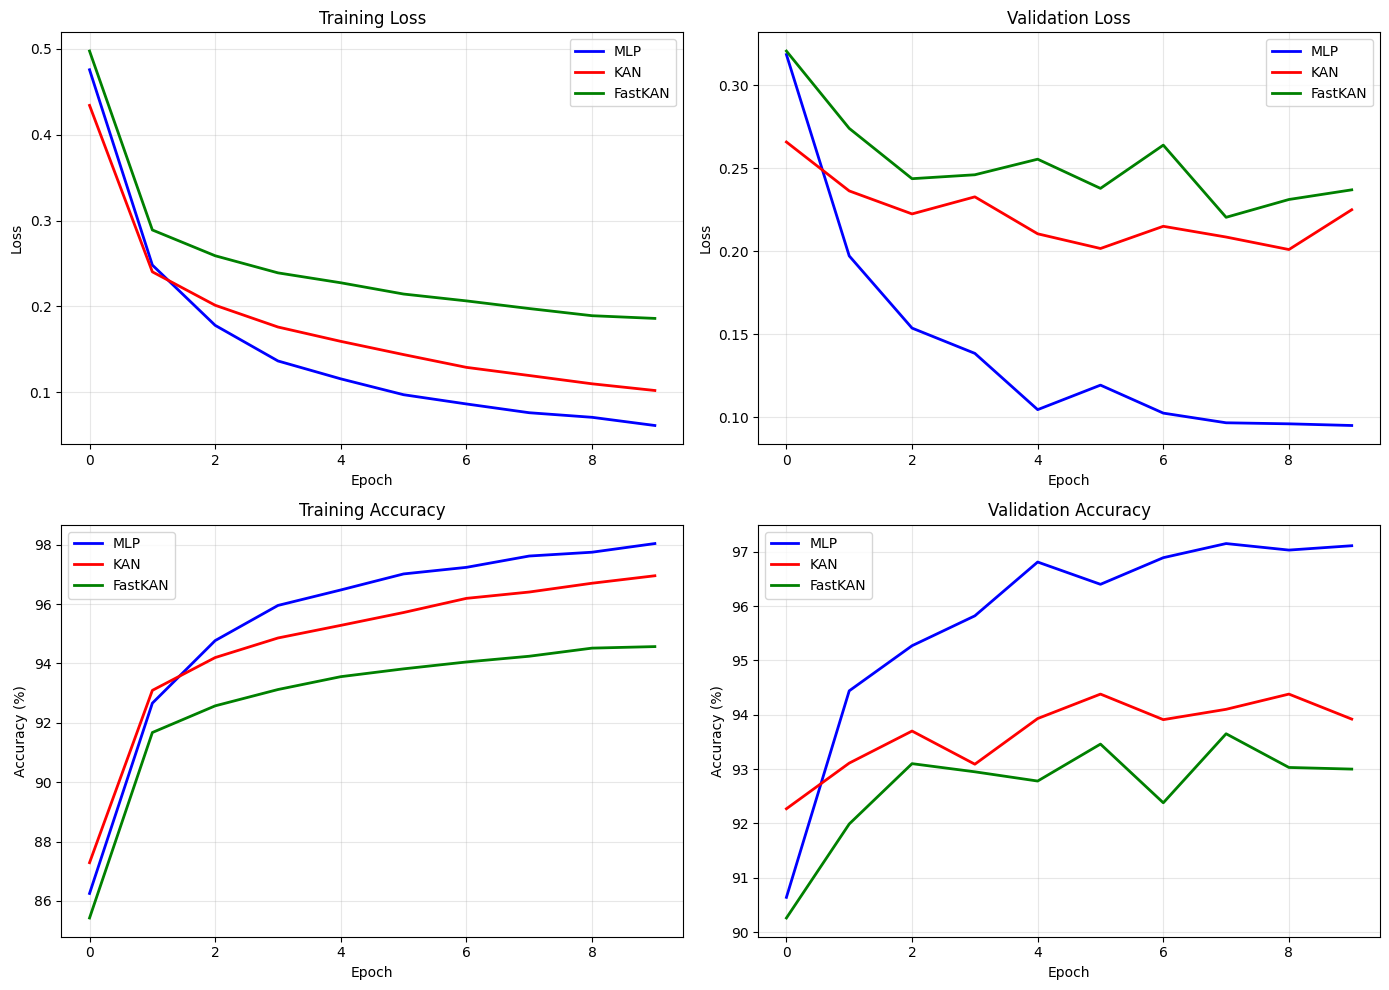

2025-11-09 19:59:02,997 - 
2025-11-09 19:59:02,998 - FINAL RESULTS SUMMARY
2025-11-09 19:59:02,998 - ============================================================
2025-11-09 19:59:02,999 - MLP        | Best Acc: 97.15% | Avg Time: 16.26s/epoch | Params: 109,386
2025-11-09 19:59:03,000 - KAN        | Best Acc: 94.38% | Avg Time: 19.27s/epoch | Params: 107,190
2025-11-09 19:59:03,001 - FastKAN    | Best Acc: 93.65% | Avg Time: 19.58s/epoch | Params: 108,034


✓ Visualization complete


In [ ]:
# ============================================
# RESULTS VISUALIZATION (BOTH DATASETS)
# ============================================

def plot_dataset_comparison(mnist_results, fashion_results):
    """Plot comparison across both datasets"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    models = ['MLP', 'KAN', 'FastKAN']
    colors = ['blue', 'red', 'green']
    
    # MNIST Training Loss
    ax = axes[0, 0]
    for model, color in zip(models, colors):
        ax.plot(mnist_results[model]['train_losses'], label=model, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('MNIST - Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # MNIST Validation Accuracy
    ax = axes[0, 1]
    for model, color in zip(models, colors):
        ax.plot(mnist_results[model]['val_accs'], label=model, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('MNIST - Validation Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # MNIST Epoch Time
    ax = axes[0, 2]
    avg_times = [np.mean(mnist_results[m]['epoch_times']) for m in models]
    ax.bar(models, avg_times, color=colors, alpha=0.7)
    ax.set_ylabel('Time (seconds)')
    ax.set_title('MNIST - Avg Training Time/Epoch')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Fashion-MNIST Training Loss
    ax = axes[1, 0]
    for model, color in zip(models, colors):
        ax.plot(fashion_results[model]['train_losses'], label=model, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Fashion-MNIST - Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Fashion-MNIST Validation Accuracy
    ax = axes[1, 1]
    for model, color in zip(models, colors):
        ax.plot(fashion_results[model]['val_accs'], label=model, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Fashion-MNIST - Validation Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Fashion-MNIST Epoch Time
    ax = axes[1, 2]
    avg_times = [np.mean(fashion_results[m]['epoch_times']) for m in models]
    ax.bar(models, avg_times, color=colors, alpha=0.7)
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Fashion-MNIST - Avg Training Time/Epoch')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('plots/dataset_comparison.png', dpi=300, bbox_inches='tight')
    logger.info("✓ Saved dataset comparison to plots/dataset_comparison.png")
    plt.show()


def plot_model_comparison_table(mnist_results, fashion_results):
    """Create comparison table figure"""
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare data
    models = ['MLP', 'KAN', 'FastKAN']
    table_data = []
    table_data.append(['Model', 'MNIST Acc', 'MNIST Time', 'Fashion Acc', 'Fashion Time', 'Params'])
    
    for model in models:
        mnist_acc = max(mnist_results[model]['val_accs'])
        mnist_time = np.mean(mnist_results[model]['epoch_times'])
        fashion_acc = max(fashion_results[model]['val_accs'])
        fashion_time = np.mean(fashion_results[model]['epoch_times'])
        
        if model == 'MLP':
            params = count_params(MLP(hidden_size=128))
        elif model == 'KAN':
            params = count_params(KAN(hidden_size=15, grid_size=5))
        else:
            params = count_params(FastKAN(hidden_size=34, grid_size=3))
        
        table_data.append([
            model,
            f'{mnist_acc:.2f}%',
            f'{mnist_time:.2f}s',
            f'{fashion_acc:.2f}%',
            f'{fashion_time:.2f}s',
            f'{params:,}'
        ])
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.15, 0.15, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style header row
    for i in range(6):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    plt.savefig('plots/comparison_table.png', dpi=300, bbox_inches='tight')
    logger.info("✓ Saved comparison table to plots/comparison_table.png")
    plt.show()


# Generate all visualizations
logger.info("\n" + "="*60)
logger.info("GENERATING VISUALIZATIONS")
logger.info("="*60)

plot_dataset_comparison(mnist_results, fashion_results)
plot_model_comparison_table(mnist_results, fashion_results)

# Print final summary
logger.info("\n" + "="*60)
logger.info("FINAL SUMMARY - BOTH DATASETS")
logger.info("="*60)
logger.info("\nMNIST Results:")
for model_name in ['MLP', 'KAN', 'FastKAN']:
    best_acc = max(mnist_results[model_name]['val_accs'])
    avg_time = np.mean(mnist_results[model_name]['epoch_times'])
    logger.info(f"  {model_name:10s} | Best Acc: {best_acc:.2f}% | Avg Time: {avg_time:.2f}s")

logger.info("\nFashion-MNIST Results:")
for model_name in ['MLP', 'KAN', 'FastKAN']:
    best_acc = max(fashion_results[model_name]['val_accs'])
    avg_time = np.mean(fashion_results[model_name]['epoch_times'])
    logger.info(f"  {model_name:10s} | Best Acc: {best_acc:.2f}% | Avg Time: {avg_time:.2f}s")

print("\n✓ All visualizations complete")